In [1]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10533650268758628750]

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("C:/Users/user8/Desktop/vib_data_new.csv")
print(df.shape)
df_err = pd.read_csv("C:/Users/user8/Desktop/vib_data_err.csv")
print(df_err.shape)

(13217, 16)
(1011, 16)


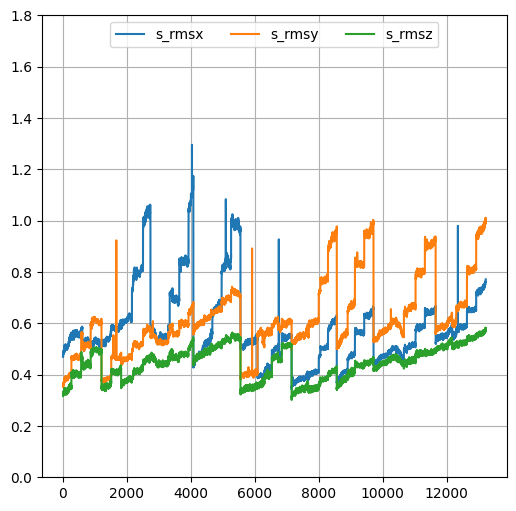

In [4]:
plt.figure(figsize=(6,6))

plt.plot(df['s_rmsx'], label='s_rmsx')
plt.plot(df['s_rmsy'], label='s_rmsy')
plt.plot(df['s_rmsz'], label='s_rmsz')
plt.legend(loc='upper center', ncol=3)  # 범례
plt.ylim([0.0, 1.8])  # y축 설정
plt.grid() # 격자

plt.show()

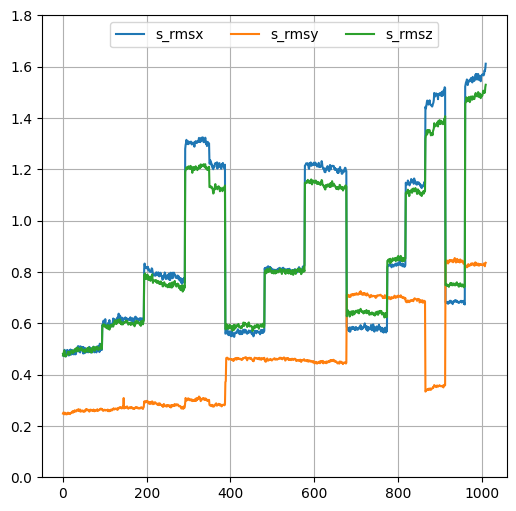

In [5]:
plt.figure(figsize=(6,6))

plt.plot(df_err['s_rmsx'], label='s_rmsx')
plt.plot(df_err['s_rmsy'], label='s_rmsy')
plt.plot(df_err['s_rmsz'], label='s_rmsz')
plt.legend(loc='upper center', ncol=3)  # 범례
plt.ylim([0.0, 1.8])  # y축 설정
plt.grid() # 격자

plt.show()

In [6]:
df['s_measuretime'] = pd.to_datetime(df.s_measuretime, format='%Y-%m-%d %H:%M')  # 문자열을 날짜형식으로 변환하여 갱신
df.index = df['s_measuretime']  # 날짜를 인덱스로 설정
data = df.sort_index(ascending=True, axis=0)  # 행단위 오름차순 정렬하여 저장

In [7]:
df_err['s_measuretime'] = pd.to_datetime(df_err.s_measuretime, format='%Y-%m-%d %H:%M')  # 문자열을 날짜형식으로 변환하여 갱신
df_err.index = df_err['s_measuretime']  # 날짜를 인덱스로 설정
data_err = df_err.sort_index(ascending=True, axis=0)  # 행단위 오름차순 정렬하여 저장

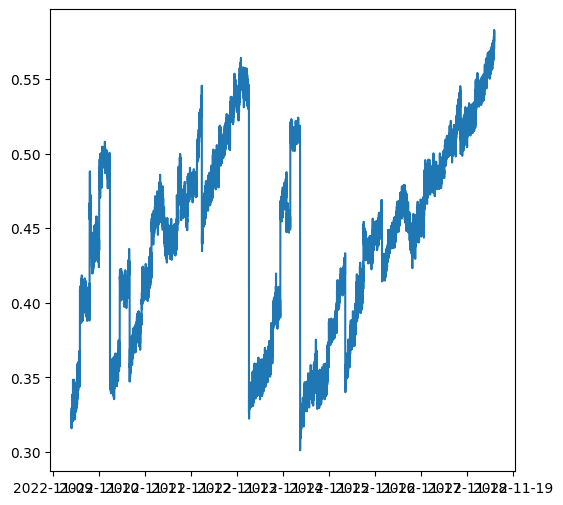

In [8]:
#rmsx 정상 그래프
plt.figure(figsize=(6,6))
plt.plot(df['s_rmsz'])
plt.show()

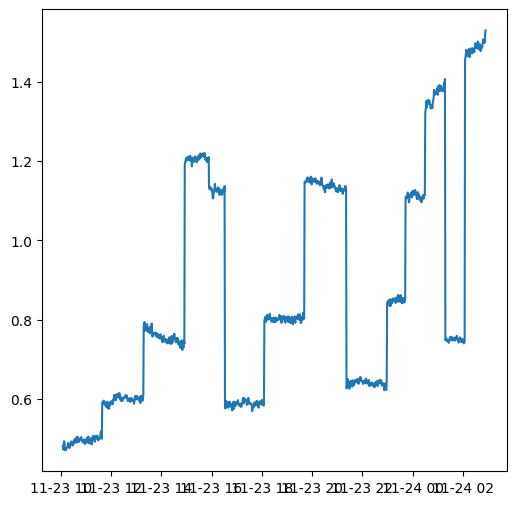

In [9]:
#rmsx err 그래프
plt.figure(figsize=(6,6))
plt.plot(df_err['s_rmsz'])
plt.show()

In [10]:
new_data = pd.DataFrame(index=range(0, len(df)), columns=['s_measuretime', 's_rmsz'])
#print(new_data)
# 날짜와 rmsx 데이터를 이용한 데이터프레임 생성
for i in range(0, len(data)) : 
    new_data['s_measuretime'][i] = data['s_measuretime'][i]  # 날짜와 rmsx
    new_data['s_rmsz'][i] = data['s_rmsz'][i]
#print(new_data)
new_data.index = new_data.s_measuretime # 인덱스 설정
new_data.drop('s_measuretime', axis=1, inplace=True) # 조건에 맞는 열을 삭제하고 덮어씀
#print(new_data)
final_data = new_data.values  # numpy 배열로 변환
print(final_data.shape)
# 80% 를 학습데이터, 20%를 테스트데이터로 설정
print(final_data.shape[0])
train_idx = int(final_data.shape[0] * 0.8) # 80% 지점의 위치를 저장
print(train_idx) # 훈련데이터 개수
print(final_data.shape[0] - train_idx)  # 테스트 데이터 개수

(13217, 1)
13217
10573
2644


In [11]:
new_data_err = pd.DataFrame(index=range(0, len(df_err)), columns=['s_measuretime', 's_rmsz'])
#print(new_data)
# 날짜와 rmsx 데이터를 이용한 데이터프레임 생성
for i in range(0, len(data_err)) : 
    new_data_err['s_measuretime'][i] = data_err['s_measuretime'][i]  # 날짜와 rmsx
    new_data_err['s_rmsz'][i] = data_err['s_rmsz'][i]
#print(new_data)
new_data_err.index = new_data_err.s_measuretime # 인덱스 설정
new_data_err.drop('s_measuretime', axis=1, inplace=True) # 조건에 맞는 열을 삭제하고 덮어씀
#print(new_data)
final_data_err = new_data_err.values  # numpy 배열로 변환
print(final_data_err)
print(final_data)

[[0.48077]
 [0.47297]
 [0.48737]
 ...
 [1.49865]
 [1.52013]
 [1.52933]]
[[0.32355]
 [0.31766]
 [0.31594]
 ...
 [0.57494]
 [0.58254]
 [0.57554]]


In [12]:
scaler = MinMaxScaler(feature_range=(0,1))  # 정규화를  위한 객체 생성
scaled_data = scaler.fit_transform(final_data)  # 스케일러를 사용하여 정규화
print(scaled_data)

[[0.07934307]
 [0.05840532]
 [0.05229107]
 ...
 [0.97298354]
 [1.        ]
 [0.97511642]]


In [13]:
scaler_err = MinMaxScaler(feature_range=(0,1))  # 정규화를  위한 객체 생성
scaled_data_err = scaler_err.fit_transform(final_data_err)  # 스케일러를 사용하여 정규화
print(scaled_data_err)
print(scaled_data)

[[0.00908172]
 [0.0017105 ]
 [0.0153189 ]
 ...
 [0.97100655]
 [0.99130574]
 [1.        ]]
[[0.07934307]
 [0.05840532]
 [0.05229107]
 ...
 [0.97298354]
 [1.        ]
 [0.97511642]]


In [14]:
# 신경망에 입력하기 위한 데이터셋 생성
# 함수로 구현
def getDataSetX(item, start, to, size) : # 원시데이터, 데이터 시작, 데이터 끝, 입력데이터 개수
    arr = []  # 공백 리스트 생성
    for i in range(start, to - (size-1)) :
        arr.append(item[i:i+size , 0])
    nparr = np.array(arr)  # 넘파이 배열로 변환
    nparr = np.reshape(nparr, (nparr.shape[0], nparr.shape[1], 1)) # 차원 확장
    return (nparr)

In [15]:
def getDataSetY(item, start, to, size) :
    arr = []
    for i in range(start + size, to + 1) :
        arr.append(item[i, 0])
    nparr = np.array(arr) # 넘파이 배열로 변환(차원변경 없음)
    return (nparr)

In [16]:
x_train = getDataSetX(scaled_data, 0, train_idx-1, 10)
y_train = getDataSetY(scaled_data, 0, train_idx-1, 10)
print(x_train.shape)
print(y_train.shape)
x_test = getDataSetX(scaled_data, train_idx, final_data.shape[0]-1, 10)
y_test = getDataSetY(scaled_data, train_idx, final_data.shape[0]-1, 10)
print(x_test.shape)
print(y_test.shape)

(10563, 10, 1)
(10563,)
(2634, 10, 1)
(2634,)


In [17]:
x_test_err = getDataSetX(scaled_data_err, 0, final_data_err.shape[0]-1, 10)
y_test_err = getDataSetY(scaled_data_err, 0, final_data_err.shape[0]-1, 10)
print(x_test_err)
print(y_test_err)

[[[0.00908172]
  [0.0017105 ]
  [0.0153189 ]
  ...
  [0.0034588 ]
  [0.00177665]
  [0.00554731]]

 [[0.0017105 ]
  [0.0153189 ]
  [0.02167894]
  ...
  [0.00177665]
  [0.00554731]
  [0.00650179]]

 [[0.0153189 ]
  [0.02167894]
  [0.01891001]
  ...
  [0.00554731]
  [0.00650179]
  [0.00763582]]

 ...

 [[0.95063175]
  [0.96021433]
  [0.95614126]
  ...
  [0.97292496]
  [0.96988197]
  [0.97421019]]

 [[0.96021433]
  [0.95614126]
  [0.96139562]
  ...
  [0.96988197]
  [0.97421019]
  [0.97100655]]

 [[0.95614126]
  [0.96139562]
  [0.95996863]
  ...
  [0.97421019]
  [0.97100655]
  [0.99130574]]]
[0.00650179 0.00763582 0.01666084 ... 0.97100655 0.99130574 1.        ]


In [18]:
lstm_model = Sequential([
    LSTM(units=10, return_sequences=True, input_shape=(x_train.shape[1],1)),
    LSTM(units=10),
    Dense(1)
])
lstm_model.compile(loss='mse', optimizer='adam')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_lstm = lstm_model.fit(x_train, y_train, epochs=20, batch_size=32,
                             validation_split=0.2)

Epoch 1/20
265/265 [==============================] - 2s 7ms/step - loss: 0.0147 - val_loss: 6.3441e-04
Epoch 2/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 5.9839e-04
Epoch 3/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 6.9027e-04
Epoch 4/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 6.0532e-04
Epoch 5/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 6.2970e-04
Epoch 6/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 5.5380e-04
Epoch 7/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 5.5489e-04
Epoch 8/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 6.9999e-04
Epoch 9/20
265/265 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 5.2801e-04
Epoch 10/20
265/265 [==============================] - 1s 4ms/st

In [20]:
lstm_model.save('C:/Users/user8/Desktop/lstm_model_rmsz.h5')

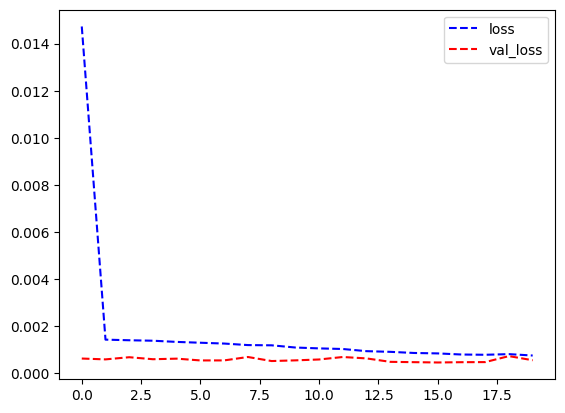

In [21]:
plt.plot(history_lstm.history['loss'], 'b--', label='loss')
plt.plot(history_lstm.history['val_loss'], 'r--', label='val_loss')
plt.legend()
plt.show()

In [22]:
pred_s_rmsz = lstm_model.predict(x_test) # 테스트 데이터셋으로 예측(정규화값)
pred_s_rmsz = scaler.inverse_transform(pred_s_rmsz) # 정규화데이터로 역변환
print(pred_s_rmsz.shape)

(2634, 1)


In [23]:
pred_s_rmsz_err = lstm_model.predict(x_test_err) # 테스트 데이터셋으로 예측(정규화값)
pred_s_rmsz_err = scaler_err.inverse_transform(pred_s_rmsz_err) # 정규화데이터로 역변환
print(pred_s_rmsz_err.shape)

(1001, 1)


In [24]:
test_data = final_data[train_idx: , : ] # 테스트 데이터 원본
print(test_data[10:, 0])  # 정답
print(pred_s_rmsz[ : , 0])        # 예측

# MAPE(Mean Absolute Percentage Error)
print(np.mean(np.abs((test_data[10:, 0] - pred_s_rmsz[ : , 0]) / test_data[10:, 0]))*100)

[0.43964 0.44462 0.43818 ... 0.57494 0.58254 0.57554]
[0.4448355  0.44125402 0.43991315 ... 0.56564826 0.5655303  0.5676266 ]
1.2811728901963568


In [25]:
test_data_err = final_data_err[0: , : ] # 오류테스트 데이터 원본
print(test_data_err[10:, 0])  # 정답
print(pred_s_rmsz_err[ : , 0])        # 예측

# MAPE(Mean Absolute Percentage Error)
print(np.mean(np.abs((test_data_err[10:, 0] - pred_s_rmsz_err[ : , 0]) / test_data_err[10:, 0]))*100)

[0.47804 0.47924 0.48879 ... 1.49865 1.52013 1.52933]
[0.49238193 0.4920494  0.49217966 ... 1.4641753  1.4637761  1.4698727 ]
2.476630408348635


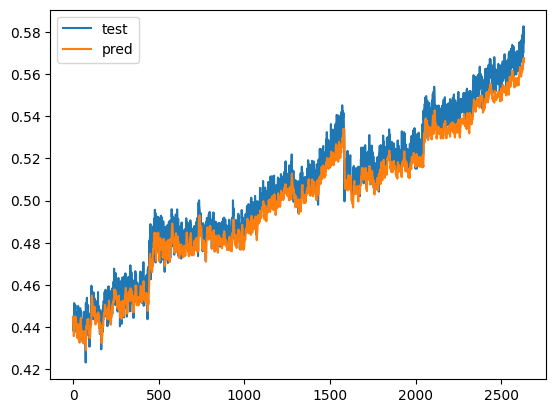

In [26]:
plt.plot(test_data[10:, 0], label='test') # 정답
plt.plot(pred_s_rmsz, label='pred')  # 예측
plt.legend()
plt.show()

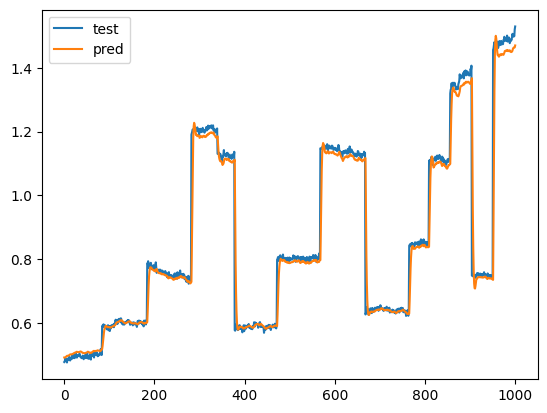

In [27]:
plt.plot(test_data_err[10:, 0], label='test') # 정답
plt.plot(pred_s_rmsz_err, label='pred')  # 예측
plt.legend()
plt.show()

In [28]:
# 에러데이터를 이용하여 예측하고 원시 데이터와 비교
